# Newton's kissing spheres and simulated annealing

Newton asked whether it was possible to stack 13 spheres of unit
radius $R=1$ around a fixed central sphere of radius 1. The 13 spheres must be in contact with the central one but have no overlap
between them. Another way to
phrase the same question is to ask what can be the maximum
radius $R$ for 13 spheres stacked around the central one
(that is always of unit radius). This is the question we will try to answer numerically. We will use two approaches:

- Direct sampling
- Simulated annealing

Let us import the relevant libraries here. There is a bit more this time because we will do some 3D graphics.

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial
from mpl_toolkits.mplot3d import Axes3D

from tqdm.auto import tqdm

## Direct sampling

The central sphere on which we will be depositing our 13 spheres is of radius 1. We place it at the origin. The 13 spheres have radius R. Because they are in contact with the central sphere, the centers of the 13 spheres are all at a distance $1+R$ from the origin.




- What is the condition that the centers of the 13 spheres need
to satisfy to ensure that there is no overlap?

$ \lVert x_k - x_{k'} \rVert \leq 2R $

- Write a program that tries to find a configuration for 13 spheres of radius $R$ so that they have no overlap. Start with a small
value for $R = 0.4$. Then, use direct sampling in order to
generate a random set of 13 vectors of norm $1+R$ indicating the positions of the centers of the 13 spheres. To do so, start by generating three Gaussian distributed $(x,y,z)$ and then normalize the vector so that it has length $1+R$. Generate 13 such points and then check whether there are overlaps. Proceed like this until you generate a legal configuration. Keep track of the number of attempts that are needed. Then, increase $R$ slowly and observe how the number of attempts increases. Is this a good strategy?

  _Hint_: the function `scipy.spatial.distance_matrix(v1, v2)` computes all pair-wise distances between two lists of points `v1` and `v2`.

In [82]:
def generate_sphere_point(r):
    """Randomly generates a point uniformly distributed on the sphere of radius r"""
    x = np.random.normal(size=3)
    x *= (r / np.linalg.norm(x))
    return x

def spheres_direct_sampling(r, max_trials=100000):
    for n_trials in range(max_trials):
        points = [generate_sphere_point(1+r) for k in range(13)]
        dist_mat = scipy.spatial.distance_matrix(points, points)
        if np.sum(dist_mat < 2*r) == 13:
            return points, n_trials
    return None, -1

In [83]:
r = 0.4
points, n_trials = spheres_direct_sampling(r)

## Plotting the spheres

It can be nice to create a figure with all the spheres. The code below defines the function `draw_all_spheres` which
will do that.

In [80]:
def draw_single_sphere(ax, origin, radius, nmesh, color='c'):

    phi, theta = np.mgrid[0.0:np.pi:nmesh*1j, 0.0:2.0*np.pi:nmesh*1j]
    x = origin[0] + radius * np.sin(phi) * np.cos(theta)
    y = origin[1] + radius * np.sin(phi) * np.sin(theta)
    z = origin[2] + radius * np.cos(phi)

    ax.plot_surface(x, y, z,  rstride=1, cstride=1, \
                    color=color, alpha=0.7, linewidth=0)

def draw_all_spheres(centers, radius, nmesh=20):

    # create 3d figure
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')

    # central sphere
    draw_single_sphere(ax, [0,0,0], 1.0, nmesh)

    # other spheres
    for center in centers:
        draw_single_sphere(ax, center, radius, nmesh, 'r')

    # cosmetics
    L = 1+radius
    ax.set_xlim([-L,L])
    ax.set_ylim([-L,L])
    ax.set_zlim([-L,L])
    ax.set_aspect("auto")
    ax.set_axis_off()
    ax.set_title("Newton spheres", fontsize=20)

- Make a plot of the configuration that has been found above

<IPython.core.display.Javascript object>


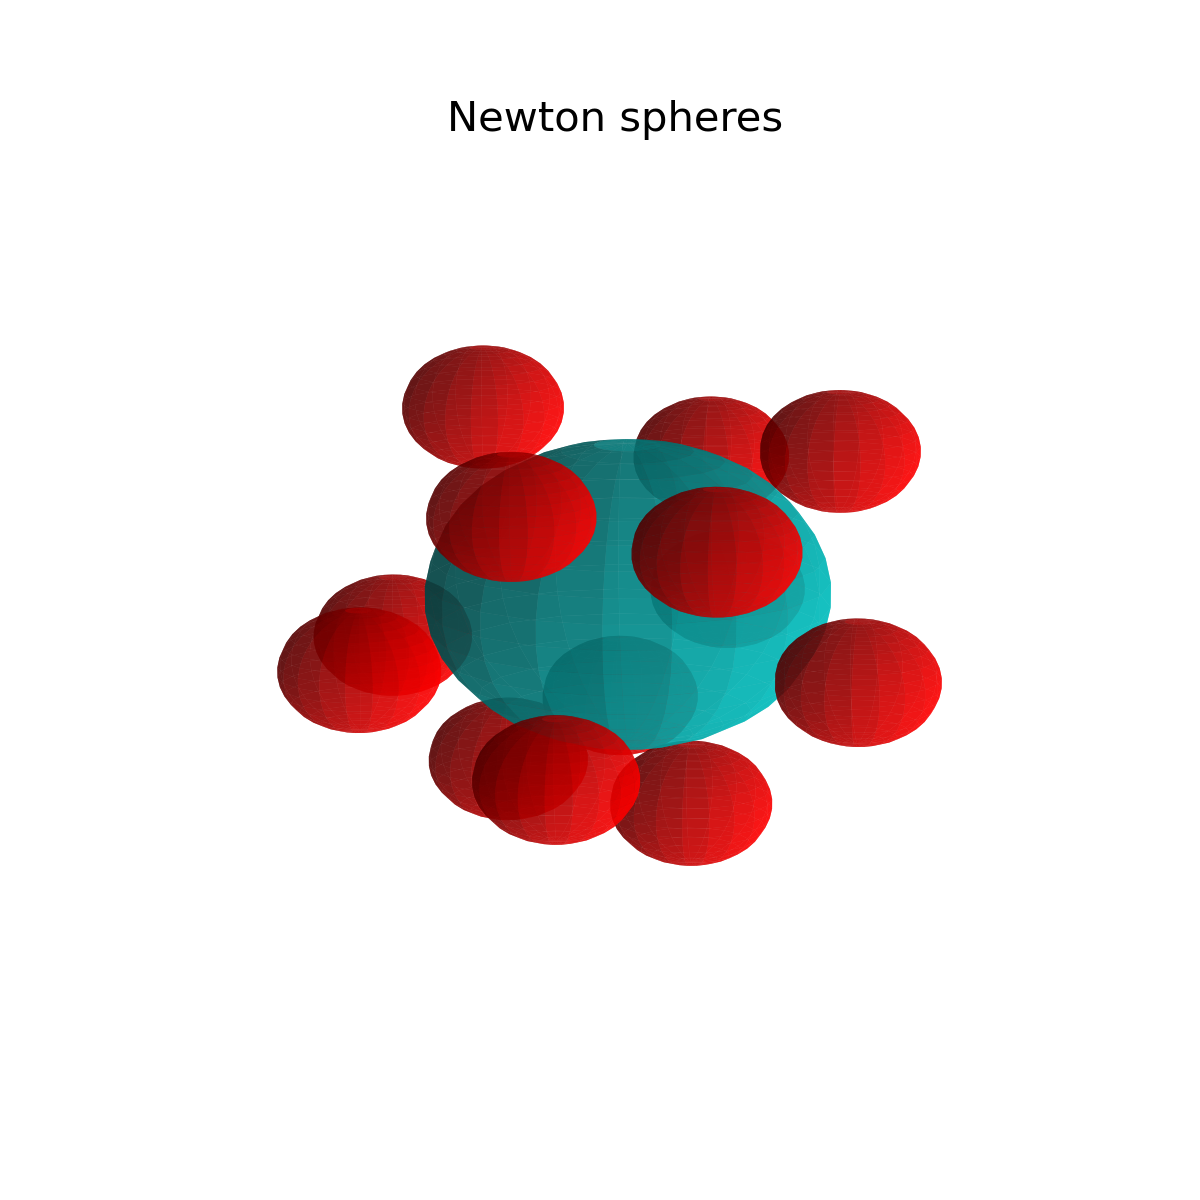

In [90]:
%matplotlib notebook
draw_all_spheres(points, r, nmesh=20)

In [95]:
%matplotlib inline

## Simulated annealing

The direct sampling approach very quickly becomes
problematic. A much more efficient strategy is to use simulated annealing. The idea is to run a Markov chain algorithm that samples allowed sphere configurations while slowly increasing the radius of the spheres. The procedure ends when it is no longer possible to increase the radii.

More precisely, the algorithm goes as follows:

1. Start with a small radius, say $R=0.4$ and generate a first legal configuration. You already wrote the code for that.

2. Move the spheres around by shifting their positions randomly. Use a Gaussian distribution of width $\sigma$ to generate the displacement vectors. Only accept moves that generate allowed configurations. Keep track of how many moves are accepted and rejected.

3. After a certain number $N_\mathrm{thumb}$ of moves, estimate the acceptance ratio for the moves from the ratio between the number accepted moves and the total number of moves $N_\mathrm{thumb}$. You can take $N_\mathrm{thumb}$ between 100 and 1000.

4. Try to have an acceptance rate close to the thumb rule. Anything between 0.4 and 0.6 will be fine. If your acceptance rate is not in this interval, adjust the width $\sigma$ of the Gaussian distribution. You can multiply or divide $\sigma$ by 2 to produce a new acceptance rate.

5. When the acceptance rate is fine, increase the radius $R$ of the spheres. There is a maximum value $R_\mathrm{max}$ for the radius that will still avoid overlaps between the spheres. It is however not a good idea to increase $R$ directly to $R_\mathrm{max}$. This has a tendency to create jammed configurations. Rather pick a new value of $R \to R + \gamma (R_\mathrm{max}-R)$. You can take $\gamma = 0.15$.

6. Proceed to point 2 with the new value of $R$. You can stop the procedure after a certain number of steps.

In general, annealing simulations can get jammed in a local minimum. For this particular problem, however, annealing works very well.

- Implement the annealing algorithm described above. Make sure you keep track of the value of $R$ during the simulation. You can also compute the density of packing of the spherical caps on top of the central sphere:

$$
\rho=\frac{N}{2} \left(1-\sqrt{1-r^2}\right) \qquad \text{with} \qquad r = \frac{1}{1 + 1/R}
$$

In [130]:
dist_mat = scipy.spatial.distance_matrix(points, points)
dist_mat + np.eye(13) * 1000

array([[1000.        ,    2.83290624,    3.15066835,    1.49297882,
           3.44206582,    2.91510518,    2.33577222,    3.20465692,
           1.88957908,    2.73185571,    2.07539603,    1.72974979,
           2.3187654 ],
       [   2.83290624, 1000.        ,    1.9726062 ,    3.3471131 ,
           1.90892366,    1.59314383,    1.58232356,    2.84515675,
           2.75633087,    3.1820187 ,    2.69051308,    1.60029316,
           3.34026294],
       [   3.15066835,    1.9726062 , 1000.        ,    3.24541235,
           1.71244093,    2.72611195,    1.57191304,    1.54112856,
           1.91806183,    2.81551879,    3.37782968,    2.98313484,
           2.24782684],
       [   1.49297882,    3.3471131 ,    3.24541235, 1000.        ,
           3.08659985,    2.80934706,    3.14960434,    2.57231023,
           2.39398295,    1.55524737,    1.57454094,    2.58633145,
           1.68807355],
       [   3.44206582,    1.90892366,    1.71244093,    3.08659985,
        1000.       

In [246]:
def simulated_annealing(r_ini, gamma=0.15, n_thumb=100):
    
    r = r_ini
    sigma = 0.2
    points, n_trials = spheres_direct_sampling(r)
    go = True
    increment = False
    
    while go:
    
        try:

            if increment:
                dist_mat = scipy.spatial.distance_matrix(points, points) + np.eye(13)*1000
                r_max = np.min(dist_mat) - 2*r
                r += gamma * r_max
                points = [(1 + r) * point / np.linalg.norm(point) for point in points]
                increment = False
                print(r)

            acceptance = 0
            for i in range(n_thumb):
                k = np.random.randint(13)
                new_points = [point for point in points]
                move = generate_sphere_point(sigma)
                new_points[k] = (1 + r) * (points[k] + move) / np.linalg.norm(points[k] + move)
                dist_mat = scipy.spatial.distance_matrix(new_points, new_points) + np.eye(13)*1000
                if np.min(dist_mat) > 2*r:
                    points = new_points
                    acceptance += 1

            if 0.4 < acceptance / n_thumb < 0.6:
                increment = True
            elif acceptance / n_thumb > 0.6:
                sigma *= 1.1
            elif acceptance / n_thumb < 0.4:
                sigma /= 1.1
            
        except:
            return points, r

In [247]:
points, r = simulated_annealing(0.4, gamma=0.15, n_thumb=500)

0.4053965977933073
0.4056543820203826
0.41190203593441344
0.4165212613113829
0.4198948713611564
0.4310517097663555
0.44183018206656316
0.44220693805240985
0.4436634168752138
0.44545211358008757
0.44580974463785944
0.4505942626960656
0.45492726015884044
0.4633526485506995
0.47942469146333805
0.4805390695055144
0.4839690767232889
0.4873969702107198
0.4885715006582018
0.4896956418118186
0.4899685325559552
0.49033329797293246
0.49350370402493
0.4961362059895224
0.4980676892985979
0.4995631159733686
0.49970767751840967
0.5026060689157147
0.5030278136168694
0.5064923971560469
0.506627863214027
0.5078610277462187
0.5093156317732255
0.5115425718457177
0.5164389124915204
0.516888246568631
0.5181573202417784
0.5187759792142529
0.5223746844570225
0.5224674091759673
0.5288578996329021
0.5319403453813228
0.5336991873320425
0.5340792152449143
0.5354234220264675
0.5391043190551352
0.5425942750898084
0.5481797829992577
0.5524082147485001
0.5622500282609911
0.5661608515943755
0.5726161907317209
0.57448

0.8933334688504696
0.8935059668744807
0.8936540536492584
0.8937379521319908
0.893794097483672
0.8938682894943434
0.8939079971319148
0.8941433697306458
0.8942611057185549
0.8943117711186479
0.8943505446902248
0.8943580668052548
0.8944214788629741
0.894722265312709
0.894820486189673
0.8949054507155361
0.8951647399135075
0.8952640592084158
0.8956269159979732
0.8956295136267566
0.8956459310601681
0.8956571396577608
0.8957417418402
0.8957993577147082
0.8958696469002861
0.8958718277332194
0.8959814221065153
0.8960558451805056
0.8961249343547909
0.8961611471804757
0.896191688345899
0.8965182345588494
0.8965660700145748
0.8965921462345974
0.8966629565977895
0.8966916585329409
0.8967961328127673
0.8968550743964474
0.8968868122280349
0.8969233107595659
0.8970688723168627
0.8971646040205337
0.8972200400309227
0.8972345366680146
0.8975658410499749
0.8975877642141454
0.8977016415140676
0.8977565726548408
0.8978535194196412
0.8980003678270867
0.8982703933870014
0.8983518723809605
0.8983529492135889


0.910152302425575
0.9101678590396232
0.9101733119737455
0.9101801858211314
0.9101822753504474
0.9101876216871361
0.9101974305435732
0.9102024217519966
0.9102062964301225
0.9102140245528492
0.9102188312882467
0.9102231882896679
0.9102482229169194
0.9102540042685785
0.9102570217090221
0.9102577193919841
0.9102752646071417
0.9102789443988949
0.9102890726726836
0.9102905556724535
0.9103039135050692
0.9103047653760783
0.910308722153624
0.9103133864532449
0.9103142135686586
0.9103175731988027
0.9103198104482353
0.9103225402747706
0.9103265021429991
0.9103294531536669
0.9103327576829203
0.910339727127597
0.9103620010212403
0.9103620974615979
0.9103620997651811
0.9103745472637154
0.9103788947553542
0.9103793645140482
0.9103939894764712
0.9104028030753261
0.9104084701477378
0.9104168850844372
0.9104289634915674
0.9104299510543434
0.9104306162807039
0.9104326616128636
0.9104346225375549
0.9104417628432269
0.9104458134617076
0.9104505942584153
0.9104537463506719
0.9104576253167341
0.9104585685179

In [248]:
dist_mat = scipy.spatial.distance_matrix(points, points) + np.eye(13)*1e3
print(np.min(dist_mat) - 2*r)

8.326917219303454e-06


In [249]:
for point in points:
    print(1 + r - np.linalg.norm(point))

0.0
2.220446049250313e-16
0.0
0.0
0.0
-2.220446049250313e-16
2.220446049250313e-16
-2.220446049250313e-16
-2.220446049250313e-16
0.0
0.0
0.0
0.0


<IPython.core.display.Javascript object>


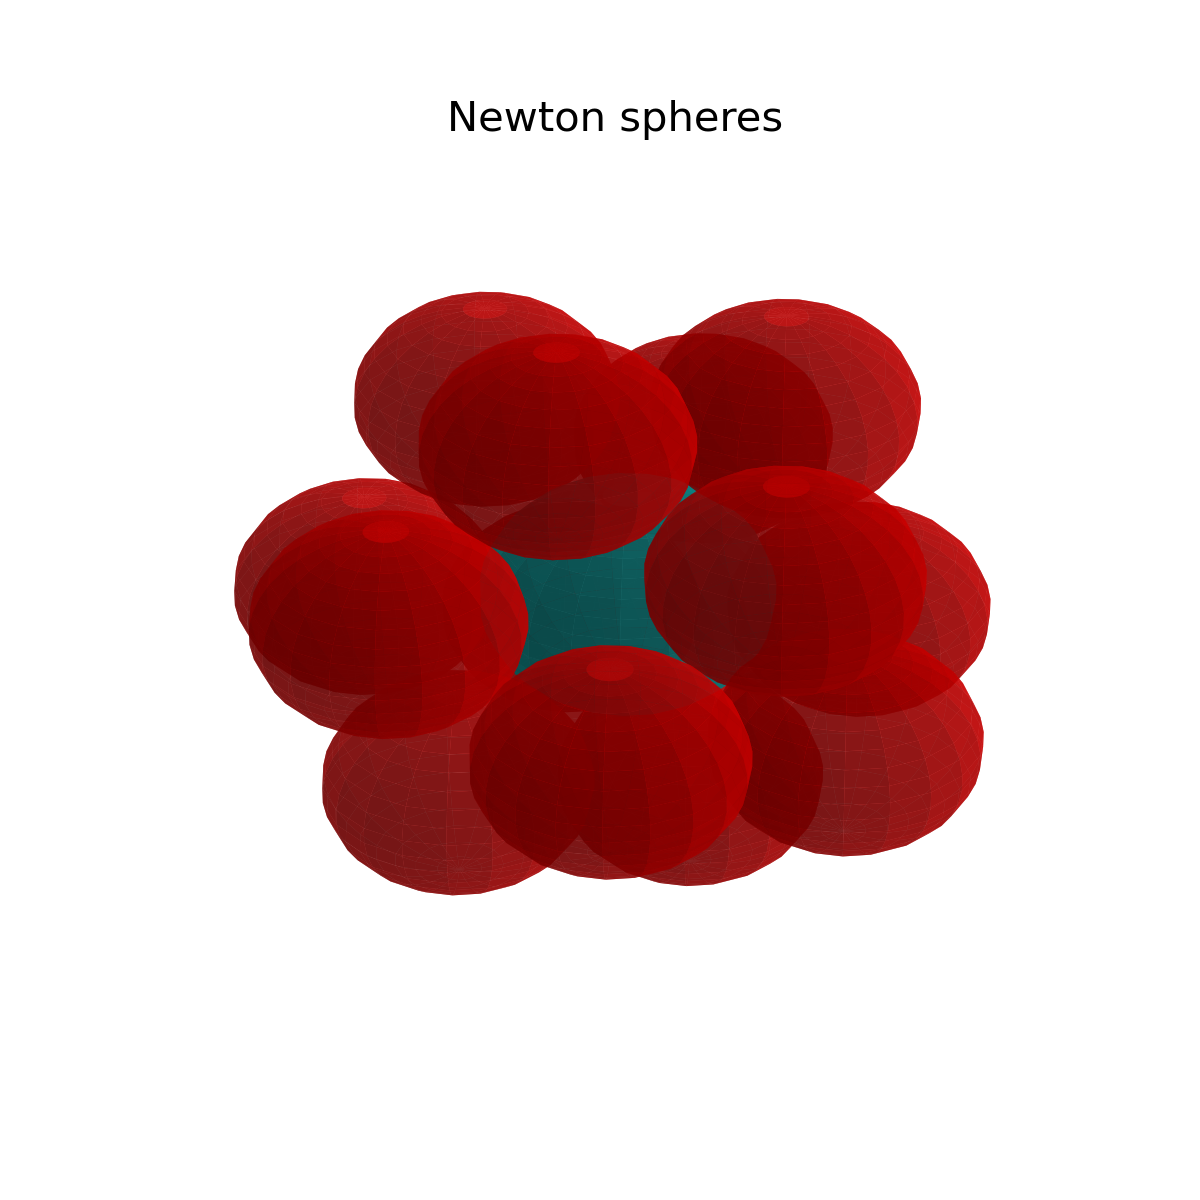

In [250]:
%matplotlib notebook
draw_all_spheres(points, r, nmesh=20)

- Print the final radius and final density. Plot the final configuration of spheres.

- Plot the evolution of the radius and of the density as a function of simulation steps. See how things
  change if you take different values for $\gamma$.